### Compare cerebellar volumes across datasets

#### Datasets
- NIMHANS
- QPN


In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting


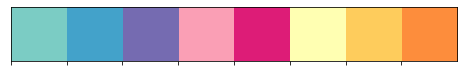

In [2]:
from enum import Enum
class my_colors(Enum):
    NIM_CONTROL = "#7bccc4"
    NIM_SERB_PD = "#43a2ca"
    NIM_METAL_PD = "#756bb1"
    QPN_CONTROL = "#fa9fb5"
    QPN_PD = "#dd1c77"
    PPMI_CONTROL = "#ffffb2"
    PPMI_PRODROMAL = "#fecc5c"
    PPMI_PD = "#fd8d3c"
    
color_list = [my_colors.NIM_CONTROL.value, my_colors.NIM_SERB_PD.value, my_colors.NIM_METAL_PD.value, 
              my_colors.QPN_CONTROL.value, my_colors.QPN_PD.value, 
              my_colors.PPMI_CONTROL.value, my_colors.PPMI_PRODROMAL.value, my_colors.PPMI_PD.value]

palette = sns.color_palette(palette=color_list) #sns.husl_palette()

hue_order = ["NIMHANS_SERB-control", "NIMHANS_SERB-PD", "NIMHANS_METAL-PD", "QPN-control", "QPN-PD", "PPMI-control", "PPMI-prodromal", "PPMI-PD"]

sns.palplot(palette)

In [3]:
projects_dir = f"/home/nikhil/projects/neuroinformatics_tools/" 

## CB
nimhans_serb_CB_agg_data_dir = f"{projects_dir}/mr_proc-nimhans_serb/analysis/cerebellum/agg_dfs/SERB/"
qpn_CB_agg_data_dir = f"{projects_dir}/mr_proc-qpn/analysis/cerebellum/agg_dfs/"
CB_vol_csv = "cerebellar_volumes.csv"

## Global + demo
nimhans_serb_CT_agg_data_dir = f"{projects_dir}/mr_proc-nimhans_serb/analysis/CT/agg_dfs/SERB/"
qpn_CT_agg_data_dir = f"{projects_dir}/mr_proc-qpn/analysis/CT/agg_dfs/"
global_vol_csv = "global_vol_ASEG_df.csv"

# save dirs
figs_dir = "../figs/population_comparisons"

demo_cols = ["participant_id","age","sex","group","hemi","dataset"]

### Read global volumes (i.e. ASEG and demo df)

In [4]:
nimhans_serb_global_ASEG_df = pd.read_csv(f"{nimhans_serb_CT_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_global_ASEG_df["dataset"] = "NIMHANS_SERB"
n_nimhans_serb_participants = len(nimhans_serb_global_ASEG_df["participant_id"].unique())

# QPN
qpn_global_ASEG_df = pd.read_csv(f"{qpn_CT_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
qpn_global_ASEG_df["dataset"] = "QPN"
n_qpn_participants = len(qpn_global_ASEG_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants)}, n_qpn_participants:{n_qpn_participants}")

nimhans_serb_demo_df = nimhans_serb_global_ASEG_df[demo_cols]
qpn_demo_df = qpn_global_ASEG_df[demo_cols]

nimhans_serb_demo_df.head()

n_nimhans_participants: 86, n_qpn_participants:201


,participant_id,age,sex,group,hemi,dataset
0,SERB088,54.0,M,PD,global,NIMHANS_SERB
1,SERB058,64.0,M,PD,global,NIMHANS_SERB
2,SERB049,62.0,M,PD,global,NIMHANS_SERB
3,SERB084,NaN,NaN,PD,global,NIMHANS_SERB
4,SERB063,56.0,M,PD,global,NIMHANS_SERB


### Get merged cerebellar volumes + demo df

In [14]:
cerebellar_lobules = ['I_II', 'III', 'IV', 'V', 'VI', 'Crus_I', 'Crus_II','VIIB', 'VIIIA', 'VIIIB', 'IX', 'X', 'CM']

def merge_CB_demo_df(CB_df, demo_df, cerebellar_lobules):
    left_lobules = list("L_" + pd.Series(cerebellar_lobules))
    right_lobules = list("R_" + pd.Series(cerebellar_lobules))
    lh_lobule_dict = dict(zip(left_lobules,cerebellar_lobules))
    rh_lobule_dict = dict(zip(right_lobules,cerebellar_lobules))

    CB_df["bids_id"] = CB_df["Subject"].str.rsplit("/", expand=True)[3].str.split("_", expand=True)[0]
    CB_df["participant_id"] = CB_df["bids_id"].str.split("-", expand=True)[1]

    # merge with demo
    CB_demo_df = pd.merge(CB_df, demo_df, on="participant_id", how="inner")
    CB_demo_df = CB_demo_df.drop(columns=["Subject","bids_id"])

    demo_cols = list(set(CB_demo_df.columns) - set(left_lobules) - set(right_lobules))

    left_CB_df = CB_demo_df[demo_cols + left_lobules].copy()
    left_CB_df["hemi"] = "left"
    right_CB_df = CB_demo_df[demo_cols + right_lobules].copy()
    right_CB_df["hemi"] = "right"

    # add total CB vol column
    left_CB_df["total_CB_vol"] = left_CB_df[left_lobules].sum(axis=1)
    right_CB_df["total_CB_vol"] = right_CB_df[right_lobules].sum(axis=1)

    # rename columns to stack vertically
    left_CB_df = left_CB_df.rename(columns=lh_lobule_dict)
    right_CB_df = right_CB_df.rename(columns=rh_lobule_dict)
    
    CB_demo_df = pd.concat([left_CB_df, right_CB_df], axis=0)

    return CB_demo_df

In [15]:
# nimhans-serb
nimhans_serb_CB_vols_df = pd.read_csv(f"{nimhans_serb_CB_agg_data_dir}/{CB_vol_csv}")
nimhans_serb_CB_vols_df = merge_CB_demo_df(nimhans_serb_CB_vols_df, nimhans_serb_demo_df, cerebellar_lobules)

# qpn
qpn_CB_vols_df = pd.read_csv(f"{qpn_CB_agg_data_dir}/{CB_vol_csv}")
qpn_CB_vols_df = merge_CB_demo_df(qpn_CB_vols_df, qpn_demo_df, cerebellar_lobules)

### Age filter
# TODO

CB_vol_df = pd.concat([nimhans_serb_CB_vols_df, qpn_CB_vols_df], axis=0)
CB_vol_df["ds_group"] = CB_vol_df["dataset"] + "-" + CB_vol_df["group"]
print(f"CB_vol_df shape: {CB_vol_df.shape}")
CB_vol_df.head()

CB_vol_df shape: (570, 21)


,dataset,participant_id,age,hemi,sex,group,I_II,III,IV,V,...,Crus_I,Crus_II,VIIB,VIIIA,VIIIB,IX,X,CM,total_CB_vol,ds_group
0,NIMHANS_SERB,SERB004,60.0,left,M,control,73.9998,588.999,1878.0,2843.99,...,8909.98,5652.99,2768.99,4209.99,3256.99,3263.99,450.999,7470.98,47297.8878,NIMHANS_SERB-control
1,NIMHANS_SERB,SERB002,NaN,left,NaN,control,62.0000,724.000,2013.0,3050.00,...,10837.00,8699.00,4216.00,5801.00,3125.00,3726.00,541.000,7966.00,57313.0000,NIMHANS_SERB-control
2,NIMHANS_SERB,SERB003,47.0,left,M,control,77.0000,873.000,1985.0,3461.00,...,10330.00,6189.00,3279.00,5076.00,2997.00,2454.00,459.000,7560.00,51935.0000,NIMHANS_SERB-control
3,NIMHANS_SERB,SERB001,56.0,left,M,control,58.0000,804.000,2243.0,3267.00,...,10737.00,6656.00,3175.00,5106.00,3515.00,3331.00,579.000,10112.00,56311.0000,NIMHANS_SERB-control
4,NIMHANS_SERB,SERB005,NaN,left,NaN,control,58.0000,656.000,1722.0,2900.00,...,8103.00,6054.00,3090.00,4079.00,2498.00,2490.00,511.000,6702.00,46298.0000,NIMHANS_SERB-control


### Plots

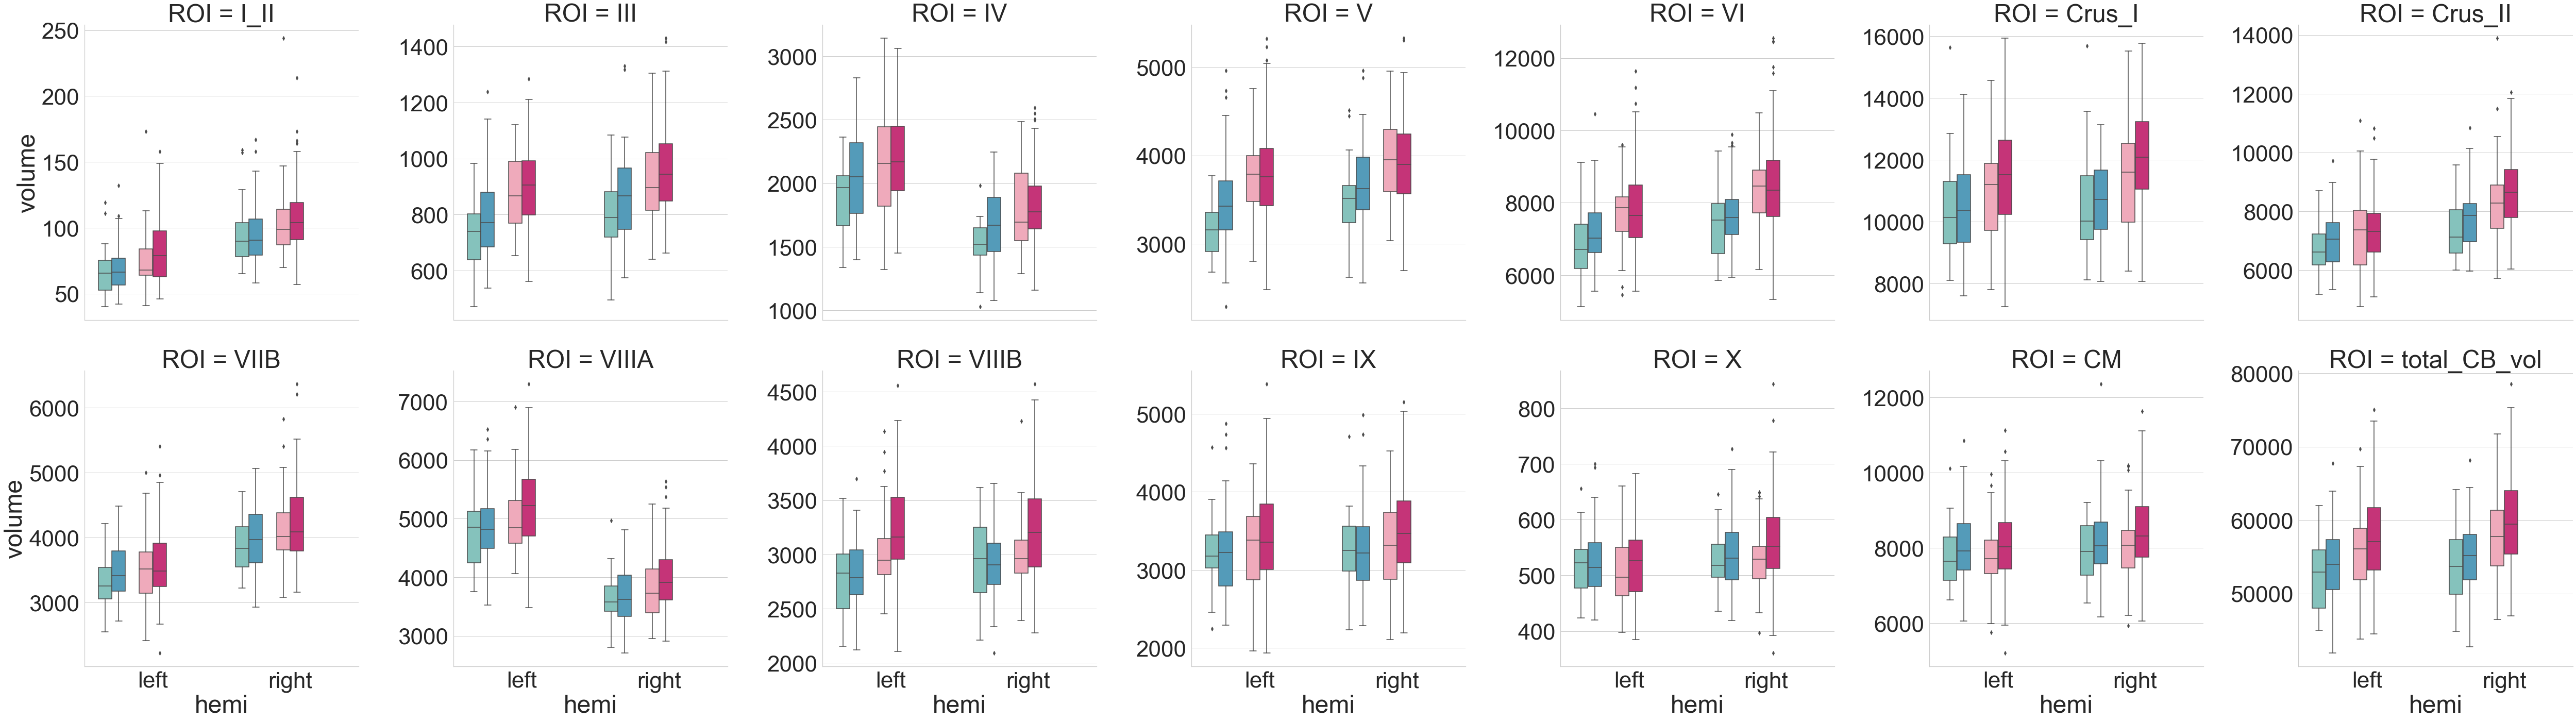

In [18]:
save_fig = False

CB_vol_df_melt = CB_vol_df.melt(
    id_vars=demo_cols + ["ds_group"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = CB_vol_df_melt.copy()

sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="ds_group", col="ROI", kind="box", col_wrap=7, hue_order=hue_order,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False, legend=False)

if save_fig:
    g.savefig(f"{figs_dir}/CB_vol.png")